In [54]:
import torch
from torch import nn
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import sklearn.metrics
from sklearn.metrics import precision_score, f1_score, matthews_corrcoef
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split

# LSTM model

In [55]:
import torch
from torch import nn


class LSTMModel(nn.Module):
    """
    A PyTorch implementation of a Long Short-Term Memory (LSTM) model for time-series forecasting.
    """

    def __init__(self,
                 input_size,
                 hidden_size,
                 num_layers,
                 output_size,
                 dropout=0):
        super(LSTMModel, self).__init__()

        self.encoder = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )

        self.decoder = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )

        self.output_layer = nn.Linear(hidden_size, input_size)

        self.hidden_size = hidden_size
        self.output_size = output_size
        self.input_size = input_size
        self.num_layers = num_layers
        self.dropout = dropout

    def forward(self, x):
        batch_size, seq_len, _ = x.shape

        # Encode
        _, (hidden, cell) = self.encoder(x)

        # Prepare decoder input: repeat the encoded representation for each timestep
        # Use the last hidden state as the encoded representation
        encoded = hidden[-1].unsqueeze(1).repeat(1, seq_len, 1)  # Shape: (batch, seq_len, hidden_size)

        # Decode: Reconstruct the sequence
        decoder_output, _ = self.decoder(encoded, (hidden, cell))

        # Reconstruct
        reconstructed = self.output_layer(decoder_output)

        return reconstructed

    def get_reconstruction_error(self, x, loss):
        """Calculate reconstruction error for anomaly detection"""
        with torch.no_grad():
            reconstructed = self.forward(x)
            # Calculate MSE for each sequence
            result = loss(reconstructed, x).amax(dim=(1, 2)).cpu().numpy()
            return result

# Configuration

In [56]:
DATA_PATH = "LSTM_preprocessed.parquet"
OUTPUT_DIR_AE = "../models_per_route_lstm_ae"

In [57]:
FEATURE_COLUMNS_K = [ "speed_over_ground", "course_over_ground",
                    # "latitude", "longitude", 
                    "x_km", "y_km", 
                    "dist_to_ref",
                    "draught",
                     # "dv"
                    ]

FEATURE_COLUMNS_B = [ "speed_over_ground", "course_over_ground",
                    # "latitude", "longitude", 
                    "x_km", "y_km", 
                    "dist_to_ref",
                    "draught",
                     # "dv"
                    ]

SEQUENCE_LENGTH = 15
SEQUENCE_STEP_LENGTH = 7

BATCH_SIZE = 32

VALIDATION_SIZE = 0.1

HIDDEN_SIZE = 16
NUM_LAYERS = 2

# Utils data

In [58]:
class Dataset:

    def __init__(self, df, features):
        self.df = df
        self.scaler = MinMaxScaler()
        self.features = features

    def get_valid_trips(self, df):
        """
        Get trips that were actually labeled
        """

        df = df[df[self.features].notna().all(axis=1) & df["y_true"].notna()]
        df = df.sort_values(['trip_id', 'time_stamp'])

        features_per_trip = df.groupby('trip_id')[self.features].apply(lambda x: x.values.tolist()).reset_index()
        features_per_trip.columns = ["trip_id", "features"]

        labels_per_trip = df.groupby('trip_id')['y_true'].apply(list).reset_index()
        df = features_per_trip.merge(labels_per_trip, on='trip_id')
        return df


    def scale_sequences(self, sequences, fit=False):
        print(f"Scaling sequences with shape: {sequences.shape}")
        if fit:
            self.scaler.fit(sequences.reshape(-1, sequences.shape[-1]))

        transformed_sequences = self.scaler.transform(sequences.reshape(-1, sequences.shape[-1]))
        return transformed_sequences.reshape(sequences.shape)

    def create_sequences(self, df, seq_length):
        xs, ys, trip_ids = [], [], []
        for trip_id, group in df.groupby('trip_id'):
            features = np.concat(group["features"].values)
            labels = np.concat(group["y_true"].values)


            for i in range(0, len(labels) - seq_length - 1, SEQUENCE_STEP_LENGTH):
                seq_features = features[i:i+seq_length]
                seq_labels = labels[i:i+seq_length]

                if np.all(seq_labels > 0):
                    seq_label = 1
                else:
                    seq_label = 0

                # seq_label = int(np.sum(seq_labels) > (len(seq_labels) / 2))


                xs.append(seq_features)
                ys.append(seq_label)
                trip_ids.append(trip_id)
        return np.array(xs), np.array(ys), np.array(trip_ids)

    def separate_sequences_by_anomaly_type(self, sequences, labels):
        normal_sequences = sequences[labels == 0]
        anomaly_sequences = sequences[labels == 1]
        return normal_sequences, anomaly_sequences

    def get_loader(self, sequences, labels, batch_size, shuffle=True):
        sequences_tensor = torch.tensor(sequences, dtype=torch.float32)
        labels_tensor = torch.tensor(labels, dtype=torch.long)
        dataset = TensorDataset(sequences_tensor, labels_tensor)
        return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    def preprocess(self, df):
        df = self.get_valid_trips(df)
        sequences, labels, trip_ids = self.create_sequences(df, SEQUENCE_LENGTH)
        unique_trip_ids = np.unique(trip_ids)
        train_trips, val_trips = train_test_split(unique_trip_ids, test_size=VALIDATION_SIZE, random_state=42)

        train_X = sequences[np.isin(trip_ids, train_trips) & (labels == 0)]
        train_y = labels[np.isin(trip_ids, train_trips) & (labels == 0)]

        val_X = sequences[np.isin(trip_ids, val_trips) & (labels == 0)]
        val_y = labels[np.isin(trip_ids, val_trips) & (labels == 0)]

        anomaly_X = sequences[labels == 1]
        anomaly_labels = labels[labels == 1]

        train_X = self.scale_sequences(train_X, fit=True)
        val_X = self.scale_sequences(val_X)
        anomaly_X = self.scale_sequences(anomaly_X)

        print(f"Training normal sequences: {len(train_X)}")
        print(f"Validation normal sequences: {len(val_X)}")
        print(f"Anomaly sequences: {len(anomaly_X)}")

        train_loader = self.get_loader(train_X, train_y, BATCH_SIZE)
        val_loader = self.get_loader(val_X, val_y, BATCH_SIZE, shuffle=False)
        anomaly_loader = self.get_loader(anomaly_X, anomaly_labels, BATCH_SIZE, shuffle=False)

        return train_loader, val_loader, anomaly_loader

In [59]:
def load_data_route(route, datapath=DATA_PATH):
    """
    Load and prepare data for a specific route using new logic
    """
    df = pd.read_parquet(datapath)
    df.sort_values(['trip_id', 'time_stamp'], inplace=True)
    df_route = df[df['start_port'] == route].copy()

    print(f"Loaded {len(df_route)} data points for route {route}")
    print(f"Number of unique trips: {len(df_route['trip_id'].unique())}")

    return df_route

# Training utils

In [60]:
def verbous_metrics(val_labels, preds):
    m = get_all_metrics(val_labels,preds)
    verbose_metrics(m)
    return m

def get_all_metrics(true_labels, predictions):

    precision = precision_score(true_labels, predictions, zero_division=0)
    recall = recall_score(true_labels, predictions, zero_division=0)
    f1 = f1_score(true_labels, predictions, zero_division=0)

    tn = np.sum((true_labels == 0) & (predictions == 0))
    fp = np.sum((true_labels == 0) & (predictions == 1))
    fn = np.sum((true_labels == 1) & (predictions == 0))
    tp = np.sum((true_labels == 1) & (predictions == 1))

    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    mcc = matthews_corrcoef(true_labels, predictions)

    metrics = {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'specificity': specificity,
        'true_positives': tp,
        'true_negatives': tn,
        'false_positives': fp,
        'false_negatives': fn,
        'mcc': mcc,
        'unlabeled_sequences': np.sum(true_labels == -1),
    }
    return metrics

def verbose_metrics(metrics):
    print("Evaluation Metrics:")
    for key, value in metrics.items():
        if (value != 0 and value != 1):
            print(f"{key.replace('_', ' ').title()}: {value:.4f}")


In [61]:
def validation(model,
               val_loader,
               loss,
               device,
               threshold = 0,
               validate = True
               ):

    errors = []
    val_labels = []

    with torch.no_grad():
        for val_X, val_y in val_loader:  # Only normal samples
            val_X = val_X.to(device)
            reconstructed = model(val_X)

            # Save per-sequence max error
            batch_errors = loss(reconstructed, val_X).amax(dim=(1, 2)).cpu().numpy()
            errors.extend(batch_errors)
            val_labels.extend(val_y.cpu().numpy())

    if validate:
        # Calculate threshold based on validation data
        threshold = np.percentile(errors, AUTOENCODER_THRESHOLD_PERCENTILE)
        print(f"Validation threshold: {threshold:.6f}")

    preds = (np.array(errors) > threshold).astype(int)
    m = verbous_metrics(val_labels,preds)
  
    return errors, preds, threshold, m

In [62]:
from tqdm import tqdm
import sklearn
from torch.utils.data import ConcatDataset, DataLoader
import copy
from torch.optim.lr_scheduler import OneCycleLR

def train(model,
          train_loader, val_loader, anomaly_loader,
          optimizer,
          loss,
          device,
          EPOCHS=20):
    
    best_mcc = -1
    best_model_state = None
    best_threshold = 0
    
    for epoch in range(EPOCHS):
        loss_history = []

        # ----- Training Loop -----
        model.train()
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
        for batch_idx, (batch_X, _) in enumerate(pbar):
            batch_X = batch_X.to(device)

            optimizer.zero_grad()

            noise = torch.randn_like(batch_X) * 0.1 # NEW
            noisy_input = batch_X + noise
            
            out = model(noisy_input)
            batch_loss = loss(out, batch_X).mean()

            loss_history.append(batch_loss.item())
            batch_loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
                        
        print(f"Training loss: {np.mean(loss_history):.6f}")

        # ----- Validation on NORMAL data (for threshold calculation) -----
        model.eval()
        print("====Val")
        normal_errors, _, threshold, metr_v = validation(model, val_loader, loss, device)
        print("====Anom")
        anomaly_errors, _, _, metr_a = validation(model, anomaly_loader, loss, device, threshold=threshold, validate=False)
        print("====Comb")

        combined_dataset = ConcatDataset([val_loader.dataset, anomaly_loader.dataset])
        combined_loader = DataLoader(combined_dataset, batch_size=val_loader.batch_size, shuffle=False)
        com_errors, _, _, metr_c = validation(model, combined_loader, loss, device, threshold=threshold, validate=False)

        mcc = metr_c.get('f1')
        if mcc > best_mcc:
            best_mcc = mcc
            best_model_state = copy.deepcopy(model.state_dict())
            best_threshold = threshold
            print("Best model updated.")
            
    metrics_final = []
    
    if best_model_state is not None:
        print(f"Best model with mcc {best_mcc}")
        model.load_state_dict(best_model_state)
        
        combined_dataset = ConcatDataset([val_loader.dataset, anomaly_loader.dataset])
        combined_loader = DataLoader(combined_dataset, batch_size=val_loader.batch_size, shuffle=False)
        com_errors, _, _, metrics_final = validation(model, combined_loader, loss, device, threshold=best_threshold, validate=False)
        

    return normal_errors, anomaly_errors, metrics_final

## Plotting

In [63]:
import matplotlib.pyplot as plt

def plot_errors(normal_errors, anomaly_errors):

    plt.hist(normal_errors, bins=100, alpha=0.5, label="Normal")
    plt.hist(anomaly_errors, bins=100, alpha=0.5, label="Anomaly")
    # plt.axvline(thresh[best_idx], color="red", linestyle="--", label="Best Threshold")
    plt.yscale("log")
    plt.legend()
    plt.title("Reconstruction Error Distribution (log scale)")
    plt.xlabel("Max Reconstruction Error")
    plt.ylabel("Log Count")
    plt.grid(True)
    plt.show()

def plot_boxplot(normal_errors, anomaly_errors):
    plt.figure(figsize=(12, 6))

    error_data = [normal_errors, anomaly_errors]
    plt.boxplot(error_data, labels=['Normal', 'Anomaly'])
    plt.ylabel('Reconstruction Error')
    plt.title('Reconstruction Error Distribution')
    plt.grid(True, alpha=0.3)
    plt.show()

# Loading data

## Kiel

In [64]:
df_KIEL = load_data_route("KIEL")
dataset_KIEL = Dataset(df_KIEL, FEATURE_COLUMNS_K)

Loaded 534244 data points for route KIEL
Number of unique trips: 420


In [65]:
train_loader_K, val_loader_K, anomaly_loader_K = dataset_KIEL.preprocess(df_KIEL)

Scaling sequences with shape: (11919, 15, 6)
Scaling sequences with shape: (1262, 15, 6)
Scaling sequences with shape: (441, 15, 6)
Training normal sequences: 11919
Validation normal sequences: 1262
Anomaly sequences: 441


## Bremenhaven

In [66]:
df_BREM = load_data_route("BREMERHAVEN")
dataset_BREM = Dataset(df_BREM, FEATURE_COLUMNS_B)

Loaded 378322 data points for route BREMERHAVEN
Number of unique trips: 703


In [67]:
train_loader_B, val_loader_B, anomaly_loader_B = dataset_BREM.preprocess(df_BREM)

Scaling sequences with shape: (5586, 15, 6)
Scaling sequences with shape: (521, 15, 6)
Scaling sequences with shape: (257, 15, 6)
Training normal sequences: 5586
Validation normal sequences: 521
Anomaly sequences: 257


# Training

## KIEL

In [95]:
model_K = LSTMModel(
    input_size=len(FEATURE_COLUMNS_K),
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    output_size=len(FEATURE_COLUMNS_K),
    dropout=0.1
)

optimizer_K = torch.optim.AdamW(model_K.parameters(), lr=0.005, weight_decay=1e-3)
loss_K = nn.MSELoss(reduction='none') 
# loss_K = nn.HuberLoss(reduction='none', delta = 0.1) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_K = model_K.to(device)

AUTOENCODER_THRESHOLD_PERCENTILE = 95

In [96]:
normal_errors_K, anomaly_errors_K, metrics_K = train(model_K,
        train_loader_K, val_loader_K, anomaly_loader_K,
          optimizer_K,
          loss_K,
          device,
          EPOCHS=20)

Epoch 1/20: 100%|██████████| 373/373 [00:02<00:00, 182.28it/s]


Training loss: 0.020896
====Val
Validation threshold: 0.096370
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.7302
F1: 0.8440
====Comb
Evaluation Metrics:
Precision: 0.8342
Recall: 0.7302
F1: 0.7787
Mcc: 0.7109
Best model updated.


Epoch 2/20: 100%|██████████| 373/373 [00:02<00:00, 182.21it/s]


Training loss: 0.004407
====Val
Validation threshold: 0.077347
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.6780
F1: 0.8081
====Comb
Evaluation Metrics:
Precision: 0.8237
Recall: 0.6780
F1: 0.7438
Mcc: 0.6710


Epoch 3/20: 100%|██████████| 373/373 [00:01<00:00, 191.75it/s]


Training loss: 0.003041
====Val
Validation threshold: 0.042022
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.8231
F1: 0.9030
====Comb
Evaluation Metrics:
Precision: 0.8501
Recall: 0.8231
F1: 0.8364
Mcc: 0.7807
Best model updated.


Epoch 4/20: 100%|██████████| 373/373 [00:01<00:00, 188.73it/s]


Training loss: 0.001791
====Val
Validation threshold: 0.035460
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.8163
F1: 0.8989
====Comb
Evaluation Metrics:
Precision: 0.8491
Recall: 0.8163
F1: 0.8324
Mcc: 0.7756


Epoch 5/20: 100%|██████████| 373/373 [00:01<00:00, 194.42it/s]


Training loss: 0.001577
====Val
Validation threshold: 0.029244
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.8322
F1: 0.9084
====Comb
Evaluation Metrics:
Precision: 0.8515
Recall: 0.8322
F1: 0.8417
Mcc: 0.7874
Best model updated.


Epoch 6/20: 100%|██████████| 373/373 [00:01<00:00, 203.08it/s]


Training loss: 0.001440
====Val
Validation threshold: 0.028600
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.7302
F1: 0.8440
====Comb
Evaluation Metrics:
Precision: 0.8342
Recall: 0.7302
F1: 0.7787
Mcc: 0.7109


Epoch 7/20: 100%|██████████| 373/373 [00:01<00:00, 200.28it/s]


Training loss: 0.001215
====Val
Validation threshold: 0.026558
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.6916
F1: 0.8177
====Comb
Evaluation Metrics:
Precision: 0.8266
Recall: 0.6916
F1: 0.7531
Mcc: 0.6815


Epoch 8/20: 100%|██████████| 373/373 [00:01<00:00, 204.89it/s]


Training loss: 0.001161
====Val
Validation threshold: 0.023140
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.7234
F1: 0.8395
====Comb
Evaluation Metrics:
Precision: 0.8329
Recall: 0.7234
F1: 0.7743
Mcc: 0.7057


Epoch 9/20: 100%|██████████| 373/373 [00:01<00:00, 191.06it/s]


Training loss: 0.001067
====Val
Validation threshold: 0.024334
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.6531
F1: 0.7901
====Comb
Evaluation Metrics:
Precision: 0.8182
Recall: 0.6531
F1: 0.7264
Mcc: 0.6516


Epoch 10/20: 100%|██████████| 373/373 [00:01<00:00, 187.92it/s]


Training loss: 0.001038
====Val
Validation threshold: 0.024245
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.6803
F1: 0.8097
====Comb
Evaluation Metrics:
Precision: 0.8242
Recall: 0.6803
F1: 0.7453
Mcc: 0.6727


Epoch 11/20: 100%|██████████| 373/373 [00:02<00:00, 185.42it/s]


Training loss: 0.001040
====Val
Validation threshold: 0.023470
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.7120
F1: 0.8318
====Comb
Evaluation Metrics:
Precision: 0.8307
Recall: 0.7120
F1: 0.7668
Mcc: 0.6971


Epoch 12/20: 100%|██████████| 373/373 [00:01<00:00, 206.03it/s]


Training loss: 0.001007
====Val
Validation threshold: 0.022130
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.6757
F1: 0.8065
====Comb
Evaluation Metrics:
Precision: 0.8232
Recall: 0.6757
F1: 0.7422
Mcc: 0.6692


Epoch 13/20: 100%|██████████| 373/373 [00:02<00:00, 161.69it/s]


Training loss: 0.000977
====Val
Validation threshold: 0.021825
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.7506
F1: 0.8575
====Comb
Evaluation Metrics:
Precision: 0.8380
Recall: 0.7506
F1: 0.7919
Mcc: 0.7264


Epoch 14/20: 100%|██████████| 373/373 [00:01<00:00, 202.22it/s]


Training loss: 0.000969
====Val
Validation threshold: 0.022712
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.7256
F1: 0.8410
====Comb
Evaluation Metrics:
Precision: 0.8333
Recall: 0.7256
F1: 0.7758
Mcc: 0.7075


Epoch 15/20: 100%|██████████| 373/373 [00:01<00:00, 189.72it/s]


Training loss: 0.000944
====Val
Validation threshold: 0.019563
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.7324
F1: 0.8455
====Comb
Evaluation Metrics:
Precision: 0.8346
Recall: 0.7324
F1: 0.7802
Mcc: 0.7126


Epoch 16/20: 100%|██████████| 373/373 [00:01<00:00, 193.82it/s]


Training loss: 0.000927
====Val
Validation threshold: 0.022142
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.6689
F1: 0.8016
====Comb
Evaluation Metrics:
Precision: 0.8217
Recall: 0.6689
F1: 0.7375
Mcc: 0.6640


Epoch 17/20: 100%|██████████| 373/373 [00:01<00:00, 199.30it/s]


Training loss: 0.000950
====Val
Validation threshold: 0.019618
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.7596
F1: 0.8634
====Comb
Evaluation Metrics:
Precision: 0.8396
Recall: 0.7596
F1: 0.7976
Mcc: 0.7332


Epoch 18/20: 100%|██████████| 373/373 [00:01<00:00, 200.81it/s]


Training loss: 0.000915
====Val
Validation threshold: 0.019270
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.7528
F1: 0.8590
====Comb
Evaluation Metrics:
Precision: 0.8384
Recall: 0.7528
F1: 0.7933
Mcc: 0.7281


Epoch 19/20: 100%|██████████| 373/373 [00:01<00:00, 202.37it/s]


Training loss: 0.000909
====Val
Validation threshold: 0.020933
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.7098
F1: 0.8302
====Comb
Evaluation Metrics:
Precision: 0.8302
Recall: 0.7098
F1: 0.7653
Mcc: 0.6954


Epoch 20/20: 100%|██████████| 373/373 [00:01<00:00, 200.81it/s]


Training loss: 0.000908
====Val
Validation threshold: 0.021076
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.8005
F1: 0.8892
====Comb
Evaluation Metrics:
Precision: 0.8465
Recall: 0.8005
F1: 0.8228
Mcc: 0.7638
Best model with mcc 0.841743119266055
Evaluation Metrics:
Precision: 0.8515
Recall: 0.8322
F1: 0.8417
Mcc: 0.7874


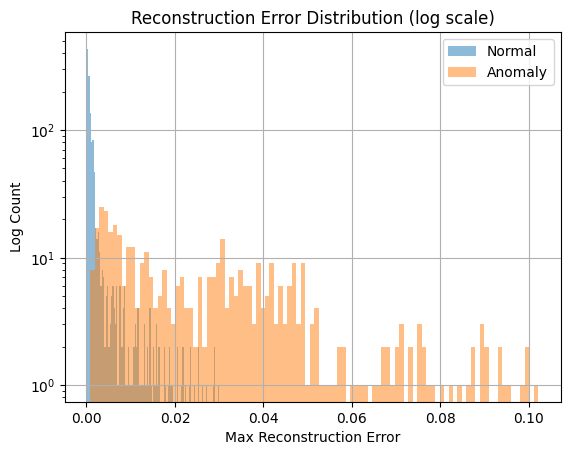

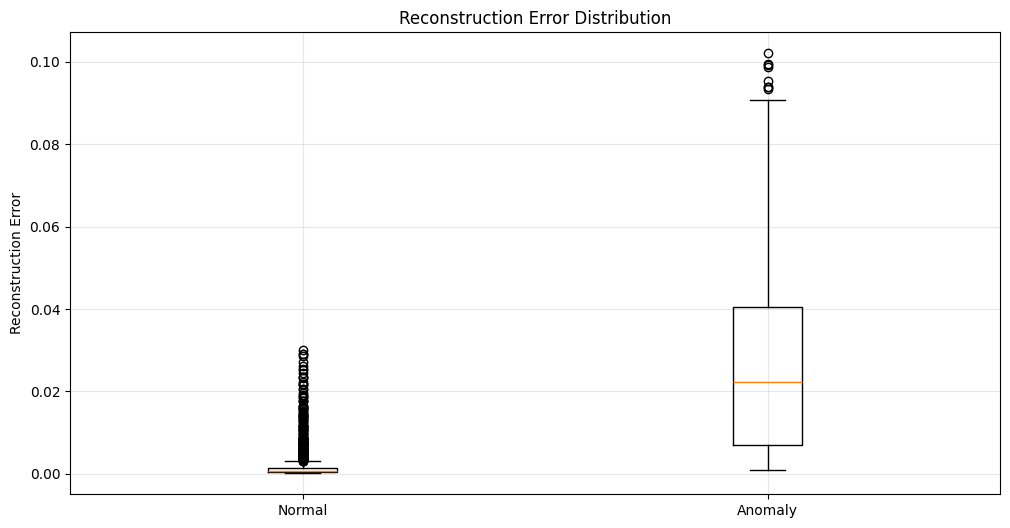

In [70]:
plot_errors(normal_errors_K, anomaly_errors_K )
plot_boxplot(normal_errors_K, anomaly_errors_K )

## BREMERHAVEN

In [91]:
model_B = LSTMModel(
    input_size=len(FEATURE_COLUMNS_B),
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    output_size=len(FEATURE_COLUMNS_B),
    dropout=0.1
)

optimizer_B = torch.optim.AdamW(model_B.parameters(), lr=0.001, weight_decay=1e-5)
# loss_B = nn.HuberLoss(reduction='none', delta = 0.1) 
loss_B = nn.MSELoss(reduction='none') 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_B = model_B.to(device)

AUTOENCODER_THRESHOLD_PERCENTILE = 95

In [93]:
normal_errors_B, anomaly_errors_B, metrics_B = train(model_B,
        train_loader_B, val_loader_B, anomaly_loader_B,
          optimizer_B,
          loss_B,
          device,
          EPOCHS=10)

Epoch 1/10: 100%|██████████| 175/175 [00:01<00:00, 165.21it/s]


Training loss: 0.008482
====Val
Validation threshold: 0.159272
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.8405
F1: 0.9133
====Comb
Evaluation Metrics:
Precision: 0.8926
Recall: 0.8405
F1: 0.8657
Mcc: 0.8032
Best model updated.


Epoch 2/10: 100%|██████████| 175/175 [00:01<00:00, 169.81it/s]


Training loss: 0.007227
====Val
Validation threshold: 0.162552
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.7977
F1: 0.8874
====Comb
Evaluation Metrics:
Precision: 0.8874
Recall: 0.7977
F1: 0.8402
Mcc: 0.7697


Epoch 3/10: 100%|██████████| 175/175 [00:00<00:00, 190.10it/s]


Training loss: 0.006485
====Val
Validation threshold: 0.129664
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.7393
F1: 0.8501
====Comb
Evaluation Metrics:
Precision: 0.8796
Recall: 0.7393
F1: 0.8034
Mcc: 0.7240


Epoch 4/10: 100%|██████████| 175/175 [00:00<00:00, 204.90it/s]


Training loss: 0.005691
====Val
Validation threshold: 0.108075
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.7160
F1: 0.8345
====Comb
Evaluation Metrics:
Precision: 0.8762
Recall: 0.7160
F1: 0.7880
Mcc: 0.7057


Epoch 5/10: 100%|██████████| 175/175 [00:00<00:00, 186.15it/s]


Training loss: 0.004806
====Val
Validation threshold: 0.100332
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.5681
F1: 0.7246
====Comb
Evaluation Metrics:
Precision: 0.8488
Recall: 0.5681
F1: 0.6807
Mcc: 0.5873


Epoch 6/10: 100%|██████████| 175/175 [00:00<00:00, 192.01it/s]


Training loss: 0.004105
====Val
Validation threshold: 0.095799
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.4553
F1: 0.6257
====Comb
Evaluation Metrics:
Precision: 0.8182
Recall: 0.4553
F1: 0.5850
Mcc: 0.4922


Epoch 7/10: 100%|██████████| 175/175 [00:00<00:00, 185.97it/s]


Training loss: 0.003719
====Val
Validation threshold: 0.093068
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.3735
F1: 0.5439
====Comb
Evaluation Metrics:
Precision: 0.7869
Recall: 0.3735
F1: 0.5066
Mcc: 0.4186


Epoch 8/10: 100%|██████████| 175/175 [00:00<00:00, 189.90it/s]


Training loss: 0.003370
====Val
Validation threshold: 0.094749
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.2763
F1: 0.4329
====Comb
Evaluation Metrics:
Precision: 0.7320
Recall: 0.2763
F1: 0.4011
Mcc: 0.3223


Epoch 9/10: 100%|██████████| 175/175 [00:00<00:00, 194.14it/s]


Training loss: 0.003162
====Val
Validation threshold: 0.096186
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.2685
F1: 0.4233
====Comb
Evaluation Metrics:
Precision: 0.7263
Recall: 0.2685
F1: 0.3920
Mcc: 0.3140


Epoch 10/10: 100%|██████████| 175/175 [00:01<00:00, 167.29it/s]


Training loss: 0.002997
====Val
Validation threshold: 0.099292
Evaluation Metrics:
====Anom
Evaluation Metrics:
Recall: 0.2568
F1: 0.4087
====Comb
Evaluation Metrics:
Precision: 0.7174
Recall: 0.2568
F1: 0.3782
Mcc: 0.3014
Best model with mcc 0.8657314629258517
Evaluation Metrics:
Precision: 0.8926
Recall: 0.8405
F1: 0.8657
Mcc: 0.8032


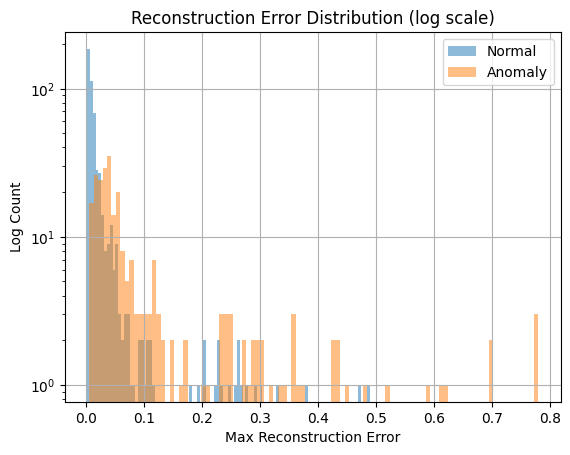

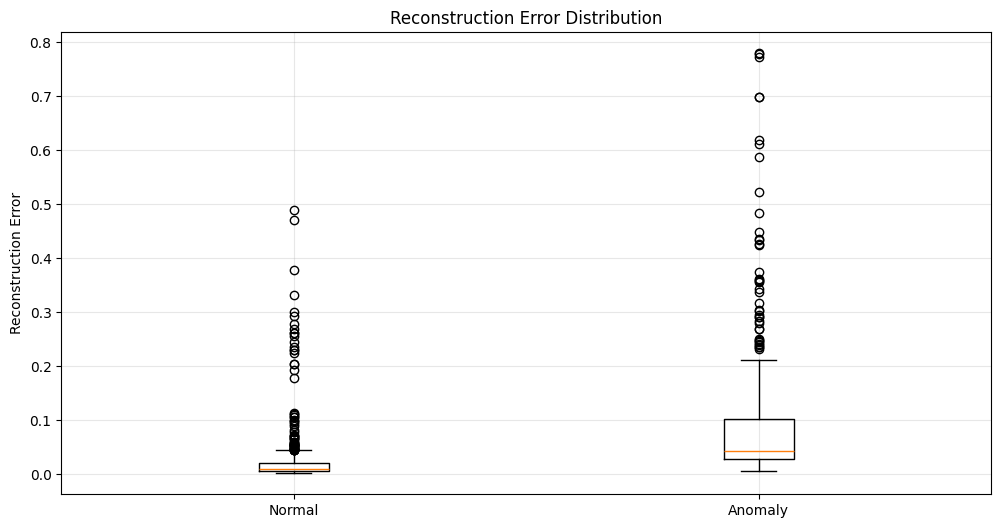

In [94]:
plot_errors(normal_errors_B, anomaly_errors_B)
plot_boxplot(normal_errors_B, anomaly_errors_B)

# Saving models

In [87]:
import joblib
from pathlib import Path

# Save to file
output_dir = Path(OUTPUT_DIR_AE)
output_dir.mkdir(exist_ok=True)

def save_model(model, scaler, loss, threshold, features, route_name):
    # Move model to CPU before saving
    model.cpu()
    # Save everything needed for inference
    lstm_artifacts = {
        "model_state": model.state_dict(),
        "model_config": {
            "input_size": model.input_size,
            "hidden_size": model.hidden_size, 
            "num_layers": model.num_layers,
            "dropout": model.dropout
        },
        "scaler": scaler,
        "threshold": threshold,
        "seq_step_length": SEQUENCE_STEP_LENGTH,
        "sequence_length": SEQUENCE_LENGTH,
        "features": features,
        "model_type": "lstm",
        "loss": loss
    }
    
    
    # Save for the specific route
    model_filename = output_dir / f"{route_name}_lstm_model.pkl"
    joblib.dump(lstm_artifacts, model_filename)

    print(f"LSTM model saved to {model_filename}")
    return model_filename

In [88]:
models_filenames = []
dispatcher_lstm = {}

threshold_B = np.percentile(normal_errors_B, AUTOENCODER_THRESHOLD_PERCENTILE)
threshold_K = np.percentile(normal_errors_K, AUTOENCODER_THRESHOLD_PERCENTILE)
scaler_K = dataset_KIEL.scaler
scaler_B = dataset_BREM.scaler

# Save BREMERHAVEN model
model_filename_BREM = save_model(model_B, scaler_B, loss_B, threshold_B, FEATURE_COLUMNS_B, "BREMERHAVEN")
models_filenames.append(model_filename_BREM)
dispatcher_lstm["BREMERHAVEN"] = str(model_filename_BREM)

# Save KIEL model
model_filename_KIEL = save_model(model_K, scaler_K, loss_K, threshold_K, FEATURE_COLUMNS_K, "KIEL")
models_filenames.append(model_filename_KIEL)
dispatcher_lstm["KIEL"] = str(model_filename_KIEL)

# Save dispatcher
dispatcher_file = output_dir / "dispatcher.pkl"
joblib.dump(dispatcher_lstm, dispatcher_file)
print(f"Dispatcher saved to {dispatcher_file}")

LSTM model saved to models_per_route_lstm_ae/BREMERHAVEN_lstm_model.pkl
LSTM model saved to models_per_route_lstm_ae/KIEL_lstm_model.pkl
Dispatcher saved to models_per_route_lstm_ae/dispatcher.pkl


In [51]:
df_10257 = df_BREM[df_BREM['trip_id'] == 24805]

In [52]:
dataset_10257 = Dataset(df_10257, FEATURE_COLUMNS_B)
df_10257 = dataset_10257.get_valid_trips(df_10257)
seq_10257, labels, _ = dataset_10257.create_sequences(df_10257, SEQUENCE_LENGTH)
X = dataset_10257.scale_sequences(seq_10257, fit=True)
loader = dataset_10257.get_loader(X, labels, BATCH_SIZE)

Scaling sequences with shape: (83, 15, 6)


In [53]:
_, _, _ ,_  = validation(model_B, loader, loss_B, device, threshold=threshold_B, validate=False)

Evaluation Metrics:
